<a href="https://colab.research.google.com/github/arnisafazla/CS490/blob/main/CS_490_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/CS490/CS490-Senior-Research-Project

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


##Experiments Rotation Representations and Testing

In [5]:
eul = np.array([dataset.X[0]])
rots = Tools.euler_to_rots(eul)

In [6]:
ort = Tools.rots_to_ort6d(rots)

In [7]:
transformed = dataset.rots_to_pos(ort, rep='6d')

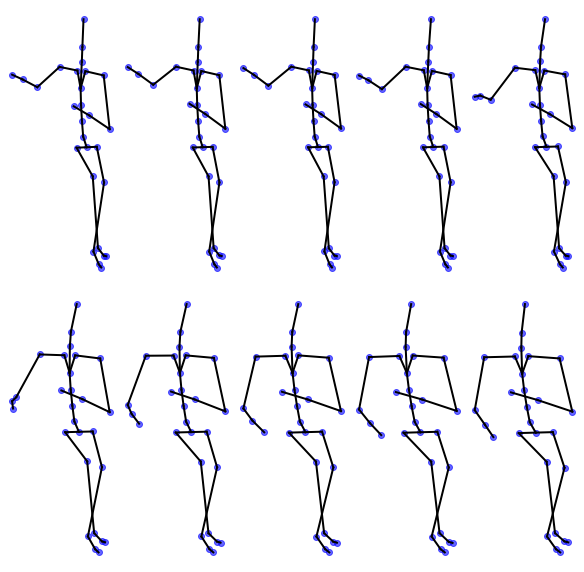

In [8]:
fig = dataset.stickfigure(transformed[0])

##Experiments Mocap Player

In [ ]:
nb_play_mocap(transformed, 'pos')

In [ ]:
import IPython
def nb_play_mocap(mocap, mf, meta=None, frame_time=1/30, scale=1, camera_z=500, base_url=None):
    data_template = 'var dataBuffer = `$$DATA$$`;'
    data_template += 'var metadata = $$META$$;'
    data_template += 'start(dataBuffer, metadata, $$CZ$$, $$SCALE$$, $$FRAMETIME$$);'
    dir_path = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project/PyMO/pymo' # os.path.dirname(os.path.realpath(__file__))


    if base_url is None:
        base_url = os.path.join(dir_path, 'mocapplayer/playBuffer.html')
    
    # print(dir_path)

    if mf == 'bvh':
        pass
    elif mf == 'pos':
        cols = list(mocap.values.columns)
        for c in cols:
            if 'rotation' in c:
                cols.remove(c)
        
        data_csv = mocap.values.to_csv(index=False, columns=cols)

        if meta is not None:
            lines = [','.join(item) for item in meta.astype('str')]
            meta_csv = '[' + ','.join('[%s]'%l for l in lines) +']'            
        else:
            meta_csv = '[]'
        
        data_assigned = data_template.replace('$$DATA$$', data_csv)
        data_assigned = data_assigned.replace('$$META$$', meta_csv)
        data_assigned = data_assigned.replace('$$CZ$$', str(camera_z))
        data_assigned = data_assigned.replace('$$SCALE$$', str(scale))
        data_assigned = data_assigned.replace('$$FRAMETIME$$', str(frame_time))

    else:
        return
    
    

    with open(os.path.join(dir_path, 'mocapplayer/data.js'), 'w') as oFile:
        oFile.write(data_assigned)

    url = '%s?&cz=200&order=xzyi&frame_time=%f&scale=%f'%(base_url, frame_time, scale)
    iframe = '<iframe frameborder="0" src=' + url + ' width="100%" height=500></iframe>'
    link = '<a href=%s target="_blank">New Window</a>'%url
    return IPython.display.HTML(iframe+link)

In [ ]:
import IPython
IPython.display.HTML(filename='/content/drive/MyDrive/CS490/CS490-Senior-Research-Project/PyMO/pymo/mocapplayer/test.html')

In [ ]:
! touch /content/drive/MyDrive/CS490/CS490-Senior-Research-Project/PyMO/pymo/mocapplayer/test2.js

In [ ]:

import IPython
from google.colab import output

IPython.display.HTML(filename='/content/drive/MyDrive/CS490/CS490-Senior-Research-Project/PyMO/pymo/mocapplayer/playBuffer.html')


In [ ]:
! cp /content/drive/MyDrive/CS490/CS490-Senior-Research-Project/PyMO/pymo/mocapplayer/data.js /usr/local/share/jupyter/nbextensions/google.colab/data.js



In [ ]:
def draw_stickfigure3d(mocap_track, frame, data=None, joints=None, draw_names=False, ax=None, figsize=(8,8)):
    from mpl_toolkits.mplot3d import Axes3D
    
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d') 
    
    if joints is None:
        joints_to_draw = mocap_track.skeleton.keys()
    else:
        joints_to_draw = joints
    
    if data is None:
        df = mocap_track.values
    else:
        df = data
        
    for joint in joints_to_draw:
        parent_x = df['%s_Xposition'%joint][frame]
        parent_y = df['%s_Zposition'%joint][frame]
        parent_z = df['%s_Yposition'%joint][frame]
        # ^ In mocaps, Y is the up-right axis 

        ax.scatter(xs=parent_x, 
                   ys=parent_y,  
                   zs=parent_z,  
                   alpha=0.6, c='b', marker='o')

        
        children_to_draw = [c for c in mocap_track.skeleton[joint]['children'] if c in joints_to_draw]
        
        for c in children_to_draw:
            child_x = df['%s_Xposition'%c][frame]
            child_y = df['%s_Zposition'%c][frame]
            child_z = df['%s_Yposition'%c][frame]
            # ^ In mocaps, Y is the up-right axis

            ax.plot([parent_x, child_x], [parent_y, child_y], [parent_z, child_z], 'k-', lw=2, c='black')
            
        if draw_names:
            ax.text(x=parent_x + 0.1, 
                    y=parent_y + 0.1,
                    z=parent_z + 0.1,
                    s=joint,
                    color='rgba(0,0,0,0.9)')

    return ax


def sketch_move(mocap_track, data=None, ax=None, figsize=(16,8)):
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    
    if data is None:
        data = mocap_track.values

    for frame in range(0, data.shape[0], 4):
#         draw_stickfigure(mocap_track, f, data=data, ax=ax)
        
        for joint in mocap_track.skeleton.keys():
            children_to_draw = [c for c in mocap_track.skeleton[joint]['children']]
            
            parent_x = data['%s_Xposition'%joint][frame]
            parent_y = data['%s_Yposition'%joint][frame]
            
            frame_alpha = frame/data.shape[0]
            
            for c in children_to_draw:
                child_x = data['%s_Xposition'%c][frame]
                child_y = data['%s_Yposition'%c][frame]
                
                ax.plot([parent_x, child_x], [parent_y, child_y], '-', lw=1, color='gray', alpha=frame_alpha)



##Version Control

In [ ]:
! git pull

Already up to date.


In [ ]:
!git config --global user.email "arnisa.fazla@ug.bilkent.edu.tr"
!git config --global user.name "arnisafazla"
! git add .

In [ ]:
! git commit -m 'model integration with 6d representation done. train only critic to see'

[main 288a066] model integration with 6d representation done. train only critic to see
 4 files changed, 85 insertions(+), 60 deletions(-)
 rewrite setup.ipynb (92%)


In [ ]:
! git add .

In [ ]:
! git check-ignore -v __pycache__/

.gitignore:1:__pycache__	__pycache__/


In [ ]:
! echo 'models/__pycache__' >> .gitignore

In [ ]:
! git add models/
! git add tools.py

In [ ]:
! git push origin main

Counting objects: 7, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 118.56 KiB | 4.23 MiB/s, done.
Total 7 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/arnisafazla/CS490-Senior-Research-Project.git
   0e88984..288a066  main -> main


##Setup Dataset

In [3]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model

# path to the cloned repo
main_dir = '/content/drive/MyDrive/CS490/CS490-Senior-Research-Project'  
# path to the dataset folder
dataset_dir = '/content/drive/MyDrive/CS490/dataset'
%cd {main_dir}
sys.path.insert(0,main_dir)
sys.path.insert(0,'/content/drive/MyDrive/CS490')
from dataset import Dataset
from tools import Tools, Metrics
from models.critic_models.LSTM_critic import define_critic
from models.critic_models.projection_critic import define_projection_critic
from models.generator_models.norm_generator import define_norm_generator
from models.generator_models.LSTM_generator import define_generator
from models.Base_WGAN import Base_WGAN

/content/drive/MyDrive/CS490/CS490-Senior-Research-Project


In [14]:
data = {}
data['X'] = dataset_2.X
data['X_val'] = dataset_2.X_val
data['Y_ord'] = dataset_2.Y_ord
data['Y_ord_val'] = dataset_2.Y_ord_val
data['Y_vec'] = dataset_2.Y_vec
data['Y_vec_val'] = dataset_2.Y_vec_val
data['data'] = dataset_2.data
data['feature_names'] = dataset_2.feature_names
data['n_features'] = dataset_2.n_features

In [4]:
# dataset = Dataset(["anger", "joy", "fear", "neutral", "sadness", "pride"], path=dataset_dir, step_size=10, frames=200, validation=0.1, data = data, representation='eul')
dataset = Dataset(["anger", "joy", "fear", "neutral", "sadness", "pride"], path=dataset_dir, step_size=10, frames=200, validation=0, representation='eul')
# dataset = Dataset(["sadness"], path=dataset_dir, step_size=10, frames=200, validation=0, representation='eul')

anger


100%|██████████| 65/65 [00:11<00:00,  5.56it/s]


joy


100%|██████████| 29/29 [00:04<00:00,  6.79it/s]


fear


100%|██████████| 32/32 [00:04<00:00,  6.91it/s]


neutral


100%|██████████| 88/88 [00:10<00:00,  8.26it/s]


sadness


100%|██████████| 47/47 [00:06<00:00,  7.26it/s]


pride


100%|██████████| 24/24 [00:03<00:00,  6.49it/s]


In [13]:
import copy
dataset_2 = copy.deepcopy(dataset)

In [5]:
Dataset.balance(dataset)

No. of samples in each class will be:  1114


##Experiments Model

In [5]:
# save this as a separate file
config = {       # change hyperparams here
        'latent_dim' : 400,
        'in_shape' : (dataset.frames, dataset.n_features*2),  # because sin and cos values for each value
        'n_classes' : dataset.emotions.shape[0],
        'init_std' : 0.01,
        'epochs' : 20,
        'batch_size' : 256,
        'n_critic' : 3,
        'dataset_balanced' : True,
        'critic_batch_norm' : False,
        'critic_instance_norm' : False,
        'critic_layer_norm' : True,
        'critic_weight_norm' : False,
        'critic_cond_layer_norm' : False,
        'generator_batch_norm' : False,
        'generator_layer_norm' : False,
        'generator_layer_norm_plus' : True,
        'critic_dropout' : 0,
        'gp_weight' : 10.0,      # for the gradient penalty used in critic
        'note' : 'first test with 6d',
        'validation' : False,
        'only_critic' : False,
        'representation' : '6d'
      }

In [ ]:
! mkdir /content/drive/MyDrive/CS490/logs/

In [30]:
critic = define_projection_critic(config)
# plot_model(critic, show_shapes=True, show_layer_names=True)

In [31]:
generator = define_norm_generator(config)

In [35]:
outputs_path = '/content/drive/MyDrive/CS490/models'
# the saved models, outputs, and config files will go to this folder
gan = Base_WGAN(config, dataset, outputs_path, '6d_repr', critic, generator)

In [36]:
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
critic_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
# Define the loss functions for the critic,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def critic_loss(real, fake):
    real_loss = tf.reduce_mean(real)
    fake_loss = tf.reduce_mean(fake)
    return fake_loss - real_loss
# Define the loss functions for the generator.
def generator_loss(fake):
    return -tf.reduce_mean(fake)

# gan = Base_WGAN('/content/drive/MyDrive/CS490/models', 'WGAN', None, critic, generator, config, dataset)

# Compile the WGAN model.
gan.compile(
    c_optimizer=critic_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    c_loss_fn=critic_loss,
)

# Start training the model.
# wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

In [ ]:
# load model
model_path = '/content/drive/MyDrive/CS490/models/one_class_2022.02.28-13:42:08/epoch_2'
outputs_path = '/content/drive/MyDrive/CS490/models'
gan = Base_WGAN(config=config, dataset=dataset, dest_dir=outputs_path, name=None, model_load=model_path, critic=None, generator=None)

>1, 1/43, c_loss=2.213, g_loss=0.028, val_loss=0.000
>1, 2/43, c_loss=0.426, g_loss=0.022, val_loss=0.000
>1, 3/43, c_loss=-0.078, g_loss=0.028, val_loss=0.000
>1, 4/43, c_loss=-0.344, g_loss=0.069, val_loss=0.000
>1, 5/43, c_loss=-0.692, g_loss=0.202, val_loss=0.000
>1, 6/43, c_loss=-1.034, g_loss=0.343, val_loss=0.000
>1, 7/43, c_loss=-1.618, g_loss=0.743, val_loss=0.000
>1, 8/43, c_loss=-2.386, g_loss=1.379, val_loss=0.000
>1, 9/43, c_loss=-3.272, g_loss=1.900, val_loss=0.000
>1, 10/43, c_loss=-3.841, g_loss=2.130, val_loss=0.000
>1, 11/43, c_loss=-4.311, g_loss=2.289, val_loss=0.000
>1, 12/43, c_loss=-4.629, g_loss=2.433, val_loss=0.000
>1, 13/43, c_loss=-4.868, g_loss=2.590, val_loss=0.000
>1, 14/43, c_loss=-4.975, g_loss=2.717, val_loss=0.000
>1, 15/43, c_loss=-5.313, g_loss=2.856, val_loss=0.000
>1, 16/43, c_loss=-5.640, g_loss=2.977, val_loss=0.000
>1, 17/43, c_loss=-5.894, g_loss=3.075, val_loss=0.000
>1, 18/43, c_loss=-6.146, g_loss=3.201, val_loss=0.000
>1, 19/43, c_loss=-6.

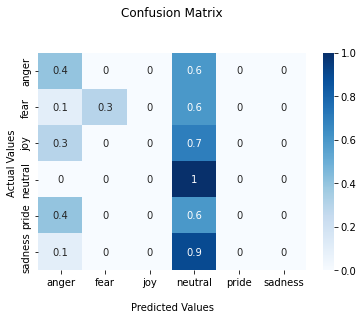

>2, 1/43, c_loss=-13.713, g_loss=7.274, val_loss=0.000
>2, 2/43, c_loss=-14.110, g_loss=7.484, val_loss=0.000
>2, 3/43, c_loss=-14.419, g_loss=7.683, val_loss=0.000
>2, 4/43, c_loss=-14.636, g_loss=7.868, val_loss=0.000
>2, 5/43, c_loss=-14.657, g_loss=8.028, val_loss=0.000
>2, 6/43, c_loss=-15.418, g_loss=8.200, val_loss=0.000
>2, 7/43, c_loss=-15.775, g_loss=8.452, val_loss=0.000
>2, 8/43, c_loss=-16.215, g_loss=8.659, val_loss=0.000
>2, 9/43, c_loss=-16.595, g_loss=8.857, val_loss=0.000
>2, 10/43, c_loss=-16.942, g_loss=9.052, val_loss=0.000
>2, 11/43, c_loss=-17.353, g_loss=9.285, val_loss=0.000
>2, 12/43, c_loss=-17.752, g_loss=9.508, val_loss=0.000
>2, 13/43, c_loss=-18.162, g_loss=9.689, val_loss=0.000
>2, 14/43, c_loss=-18.540, g_loss=9.943, val_loss=0.000
>2, 15/43, c_loss=-18.903, g_loss=10.148, val_loss=0.000
>2, 16/43, c_loss=-19.406, g_loss=10.362, val_loss=0.000
>2, 17/43, c_loss=-19.756, g_loss=10.631, val_loss=0.000
>2, 18/43, c_loss=-20.151, g_loss=10.841, val_loss=0.0

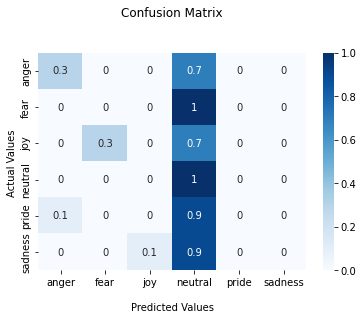

>3, 1/43, c_loss=-32.311, g_loss=17.644, val_loss=0.000
>3, 2/43, c_loss=-32.799, g_loss=17.982, val_loss=0.000
>3, 3/43, c_loss=-33.274, g_loss=18.259, val_loss=0.000
>3, 4/43, c_loss=-33.879, g_loss=18.568, val_loss=0.000
>3, 5/43, c_loss=-34.348, g_loss=18.884, val_loss=0.000
>3, 6/43, c_loss=-34.864, g_loss=19.189, val_loss=0.000
>3, 7/43, c_loss=-35.436, g_loss=19.484, val_loss=0.000
>3, 8/43, c_loss=-36.019, g_loss=19.795, val_loss=0.000
>3, 9/43, c_loss=-36.522, g_loss=20.154, val_loss=0.000
>3, 10/43, c_loss=-37.112, g_loss=20.453, val_loss=0.000
>3, 11/43, c_loss=-37.635, g_loss=20.786, val_loss=0.000
>3, 12/43, c_loss=-38.238, g_loss=21.111, val_loss=0.000
>3, 13/43, c_loss=-38.786, g_loss=21.423, val_loss=0.000
>3, 14/43, c_loss=-39.403, g_loss=21.769, val_loss=0.000
>3, 15/43, c_loss=-39.872, g_loss=22.107, val_loss=0.000
>3, 16/43, c_loss=-40.508, g_loss=22.462, val_loss=0.000
>3, 17/43, c_loss=-41.036, g_loss=22.786, val_loss=0.000
>3, 18/43, c_loss=-41.716, g_loss=23.129

In [ ]:
logs_path = '/content/drive/MyDrive/CS490/logs' # path to the tensorboard logs
gan.train(logs_path)

In [37]:
gan.save_checkpoint('/content', n_samples=1)

In [22]:
138/6

23.0

In [23]:
dataset.rots_to_pos(np.array([outputs[0].reshape((200,23,6))]), rep='6d')

In [29]:
a = tf.convert_to_tensor(np.arange(10))

In [37]:
tf.is_tensor(a)

True

In [26]:
for dir in os.listdir('/content/drive/MyDrive/CS490/models'):
  if 'epoch_1' not in os.listdir('/content/drive/MyDrive/CS490/models/' + dir):
    ! rm -rf {'/content/drive/MyDrive/CS490/models/' + dir}

In [28]:
! rm -rf /content/drive/MyDrive/CS490/models/6d_repr2022.06.01-13:01:49

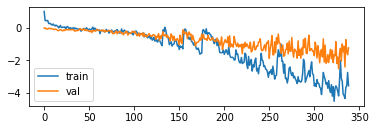

In [22]:
plt.subplot(2, 1, 1)
plt.plot(np.array(gan.train_metrics)[0], label='train')
plt.plot(np.array(gan.train_metrics)[2], label='val')
plt.legend()

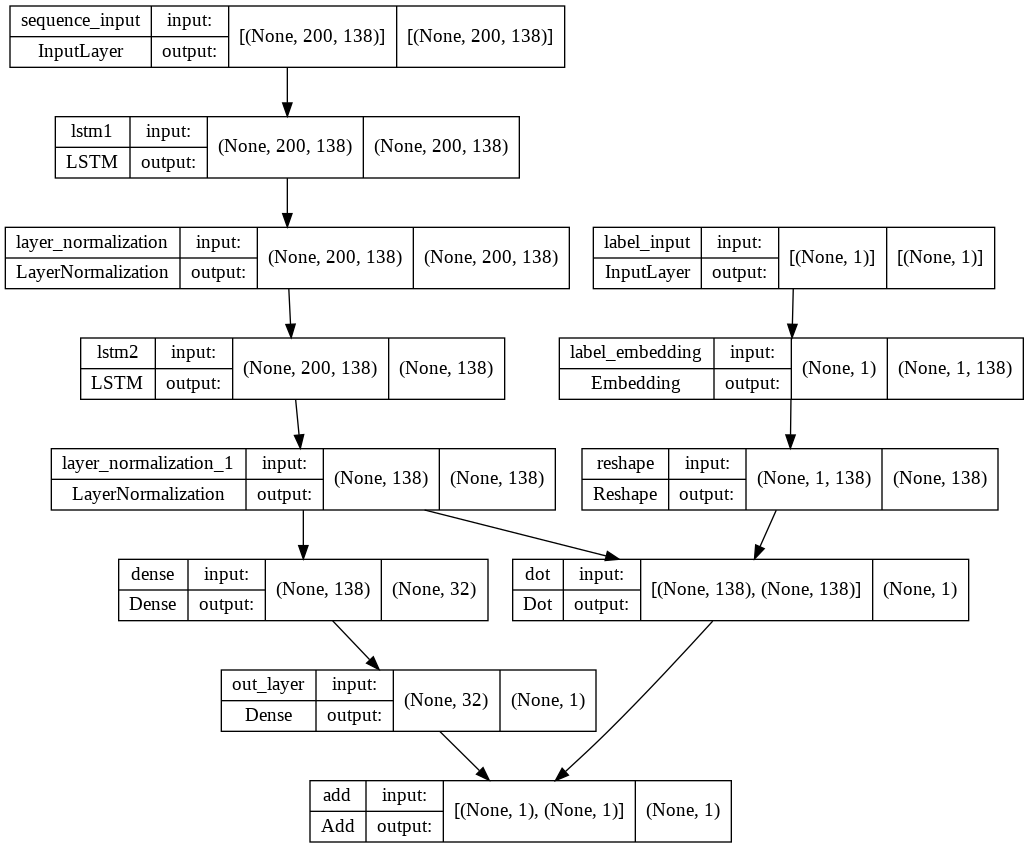

In [24]:
from keras.utils.vis_utils import plot_model
plot_model(critic, show_shapes=True, show_layer_names=True)

In [ ]:
! rm -rf /content/drive/MyDrive/CS490/models/WGAN2022.01.27-14:10:21

In [ ]:
generator = define_generator(config)

In [ ]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 400)]        0           []                               
                                                                                                  
 lat_upsample (Dense)           (None, 27600)        11067600    ['seq_input[0][0]']              
                                                                                                  
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 reshape_2 (Reshape)            (None, 200, 138)     0           ['lat_upsample[0][0]']           
                                                                                          

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/one_class_2022.02.28-09:48:19/epoch_1', 'train_metrics.txt')) as file:
  tm = json.load(file)

In [ ]:
cm

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [10.0, 10.0, 10.0, 10.0, 10.0, 10.0]]

<function matplotlib.pyplot.figure>

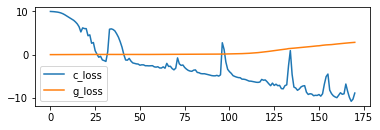

In [ ]:
Base_WGAN.plot_history(gan.train_metrics)

In [ ]:
import json
with open(os.path.join('/content/drive/MyDrive/CS490/models/WGAN_layer_norm2022.02.12-20:27:59/epoch_9', 'cm.txt')) as file:
  cm = json.load(file)

##Extras

In [13]:
import logging, copy, math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys
import tensorflow as tf

main_dir = os.getcwd()
sys.path.append(os.path.join(main_dir, 'PyMO'))

class Tools(object):
  @staticmethod
  def _from_euler(y):
    # change to YXZ from XYZ first

    ca = np.cos(y[:,0] * np.pi / 180)
    cb = np.cos(y[:,1] * np.pi / 180)
    cg = np.cos(y[:,2] * np.pi / 180)
    sa = np.sin(y[:,0] * np.pi / 180)
    sb = np.sin(y[:,1] * np.pi / 180)
    sg = np.sin(y[:,2] * np.pi / 180)        
    return np.stack((np.stack((cg*cb+sa*sb*sg, sg*ca, -cg*sb+sg*sa*cb), axis=1),
                          np.stack((-sg*cb+cg*sa*sb, cg*ca, sg*sb+cg*sa*cb), axis=1),
                          np.stack((ca*sb, -sa, ca*cb), axis=1)), axis=1)

  @staticmethod
  # convert euler values (shape: tracks x frames x features) of YXZ order
  # to rotation matrices (shape: tracks x frames x joints x 3 x 3)
  def euler_to_rots(eul):
      shape = (eul.shape[0], eul.shape[1], int(eul.shape[2]/3), 3, 3)
      eul2 = eul.reshape(-1, 3)
      eul3 = eul2.copy()
      eul3[:,0] = eul2[:,1]
      eul3[:,1] = eul2[:,0]
      rots = Tools._from_euler(eul3).reshape((shape))
      return rots

  @staticmethod
  # given rotation matrices (shape: tracks x frames x joints x 3 x 3)
  # return them as list of python dictionaries (keys are joints)
  # data is mocap data
  def rots_to_dict(rots, dataset):
    joints = []
    data = dataset.data
    for joint in data.traverse():
      joints.append(joint)
    joints2 = []
    for joint in dataset.rotation_features:
      joints2.append(joint.split('_')[0])
    joints = np.array(joints2).reshape(-1,3)[:,0]
    rots_tracks = []
    for j in range(rots.shape[0]):
      rots_dict = {}
      for i in range(len(joints)):
        rots_dict[joints[i]] = rots[j,:,i,:,:]
      rots_tracks.append(rots_dict)
    return rots_tracks

  # Adapted from "On the continuity of rotation representations in neural networks"
  # Yi Zhou, Connelly Barnes, Jingwan Lu, Jimei Yang, Hao Li.
  # Conference on Neural Information Processing Systems (NeurIPS) 2019.
  @staticmethod
  def tf_rotation6d_to_matrix(r6d):
    """ Compute rotation matrix from 6D rotation representation.
      Implementation base on 
          https://arxiv.org/abs/1812.07035
      [Inputs]
          6D rotation representation (last dimension is 6)
      [Returns]
          flattened rotation matrix (last dimension is 9)
    """
    tensor_shape = r6d.get_shape().as_list()

    if not tensor_shape[-1] == 6:
      raise AttributeError("The last demension of the inputs in tf_rotation6d_to_matrix should be 6, \
          but found tensor with shape {}".format(tensor_shape[-1]))

    r6d   = tf.reshape(r6d, [-1,6])
    x_raw = r6d[:,0:3]
    y_raw = r6d[:,3:6]

    x = tf.nn.l2_normalize(x_raw, axis=-1)
    z = tf.linalg.cross(x, y_raw)
    z = tf.nn.l2_normalize(z, axis=-1)
    y = tf.linalg.cross(z, x)

    x = tf.reshape(x, [-1,3,1])
    y = tf.reshape(y, [-1,3,1])
    z = tf.reshape(z, [-1,3,1])
    matrix = tf.concat([x,y,z], axis=-1)

    if len(tensor_shape) == 1:
      matrix = tf.reshape(matrix, [9])
    else:
      output_shape = tensor_shape[:-1] + [9]
      matrix = tf.reshape(matrix, output_shape)

    return matrix

  @staticmethod
  def tf_matrix_to_rotation6d(mat):
    """ Get 6D rotation representation for rotation matrix.
      Implementation base on 
          https://arxiv.org/abs/1812.07035
      [Inputs]
          flattened rotation matrix (last dimension is 9)
      [Returns]
          6D rotation representation (last dimension is 6)
    """
    tensor_shape = mat.get_shape().as_list()

    if not ((tensor_shape[-1] == 3 and tensor_shape[-2] == 3) or (tensor_shape[-1] == 9)):
      raise AttributeError("The inputs in tf_matrix_to_rotation6d should be [...,9] or [...,3,3], \
          but found tensor with shape {}".format(tensor_shape[-1]))
    mat = tf.reshape(mat, [-1, 3, 3])
    r6d = tf.concat([mat[...,0], mat[...,1]], axis=-1)
    if len(tensor_shape) == 1:
      r6d = tf.reshape(r6d, [6])
    return r6d

  @staticmethod
  # given rotation matrices (shape: tracks x frames x joints x 3 x 3)
  # return tf tensor ort6d representation (shape: tracks x frames x joints x 6)
  def rots_to_ort6d(rots):
    if tf.is_tensor(rots) == False:
      rots = tf.convert_to_tensor(rots)
    return tf.reshape(Tools.tf_matrix_to_rotation6d(rots), [rots.shape[0],rots.shape[1],rots.shape[2],6])

  @staticmethod
  # given tf tensor ort6d representation (shape: tracks x frames x joints x 6)
  # return np array rotation matrices (shape: tracks x frames x joints x 3 x 3)
  def ort6d_to_rots(ort6d):
    if tf.is_tensor(ort6d) == False:
      ort6d = tf.convert_to_tensor(ort6d)
    shape = [ort6d.shape[0], ort6d.shape[1], ort6d.shape[2], 3, 3]
    return np.array(tf.reshape(Tools.tf_rotation6d_to_matrix(ort6d), shape))

  @staticmethod
  def generate_latent_points(latent_dim, n_samples, n_classes):
    # generate points in the latent space
    x_input = np.random.normal(size=latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.randint(0, n_classes, n_samples)
    return [tf.convert_to_tensor(labels), tf.convert_to_tensor(z_input)]

  @staticmethod
  def named_logs(names, logs):
    result = {}
    for l in zip(names, logs):
      result[l[0]] = l[1]
    return result

  @staticmethod
  def draw_confusion_matrix(cm, names):
    names = names.flatten()
    ax = sns.heatmap(np.array(cm) / 10, annot=True, cmap='Blues')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(names)
    ax.yaxis.set_ticklabels(names)
    ## Display the visualization of the Confusion Matrix.
    plt.show()

class Metrics(object):
  @staticmethod
  def confusion_matrix(critic, n_classes, n_samples, dataset, val=False):
    cm = np.zeros((n_classes,n_classes))
    device_name = tf.test.gpu_device_name()
    if device_name == '/device:GPU:0':
      for label in range(n_classes):
        for i in range(n_samples):
          [labels_real, X_real], y_real = dataset.generate_real_samples(1, val=val)
          while int(labels_real.numpy().item()) != label:
            [labels_real, X_real], y_real = dataset.generate_real_samples(1, val=val)
          with tf.device('/device:GPU:0'):
            probs = critic.predict([np.arange(n_classes), np.repeat(X_real, n_classes, axis=0)])
            cm[int(labels_real.numpy().item()), np.argmax(probs)] += 1
            # rows are the actual values, cols are the predicted values
      return cm.tolist()
    else:
      with tf.device('/cpu:0'):
        logging.error('Not connected to GPU')
  @staticmethod
  def critic_loss(real, fake):
      real_loss = tf.reduce_mean(real)
      fake_loss = tf.reduce_mean(fake)
      return fake_loss - real_loss
  @staticmethod
  def generator_loss(fake):
      return -tf.reduce_mean(fake)




In [34]:
import os, sys, logging, json, re
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import datetime, os
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import load_model
from keras.utils.vis_utils import plot_model

main_dir = os.getcwd()
sys.path.append(main_dir)
from tools import Tools, Metrics
from models.generator_models.norm_generator import ConditionalBatchNorm, ConditionalLayerNormPlus, ConditionalLayerNorm

class Base_WGAN(keras.Model):
    def __init__(
        self,
        config,
        dataset,
        dest_dir = None,
        name = None,
        critic = None,
        generator = None, 
        model_load = None     # None or path to a specific epoch 
    ):
        super(Base_WGAN, self).__init__()
        self.dataset = dataset
        self.logger = logging.getLogger()
        self.logger.setLevel(logging.DEBUG)
        logging.basicConfig(filename="/content/test.log",
                    format='%(asctime)s %(message)s',
                    filemode='w')
        if model_load == None:
          self.config = config
          self.critic = critic
          if self.config['only_critic'] == False:
            self.generator = generator
          self.model_name = name + datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S")
          self.model_dir = os.path.join(dest_dir, self.model_name)
          self.train_metrics = [list() for i in range(3)]   # c_loss, g_loss
          self.start_epoch = 0
        else:
          self.model_dir = model_load[0:-len(os.path.basename(model_load))]
          with open(os.path.join(self.model_dir, 'config.json')) as file:
            self.config = json.load(file)
          if os.path.basename(model_load)[:5] != 'epoch':
            logging.error('model_load needs to be a path to an epoch folder, as in epoch_4.')
          self.critic = load_model(os.path.join(model_load, 'critic.h5'))
          if self.config['only_critic'] == False:
            if self.config['generator_batch_norm']:
              self.generator = load_model(os.path.join(model_load, 'generator.h5'), custom_objects={'ConditionalBatchNorm':ConditionalBatchNorm})
            elif self.config['generator_layer_norm']:
              self.generator = load_model(os.path.join(model_load, 'generator.h5'), custom_objects={'ConditionalLayerNorm':ConditionalLayerNorm})
            elif self.config['generator_layer_norm_plus']:
              self.generator = load_model(os.path.join(model_load, 'generator.h5'), custom_objects={'ConditionalLayerNormPlus':ConditionalLayerNormPlus})
          self.model_dir = model_load[0:-len(os.path.basename(model_load))]
          with open(os.path.join(model_load, 'train_metrics.txt')) as file:
            self.train_metrics = json.load(file)
          self.start_epoch = int(re.match('.*?([0-9]+)$', model_load).group(1))
    def compile(self, c_optimizer, g_optimizer, c_loss_fn, g_loss_fn):
        super(Base_WGAN, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_loss_fn = c_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_seq, real_labels, fake_seq):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, self.config['in_shape'][0], self.config['in_shape'][1],], 0.0, 1.0)
        diff = fake_seq - real_seq
        # self.logger.info('fake_seq: {}, real_seq: {}, diff: {}, alpha: {}'.format(fake_seq.shape, real_seq.shape, diff.shape, alpha.shape))
        interpolated = real_seq + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.critic([real_labels, interpolated], training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    # logdir is the general destination path for the tensorflow board logs.
    def train(self, logdir=None, verbose=2):  #   for now no tensorboard
        if not os.path.exists(self.model_dir):
            self.logger.info('Creating new model directory.')
            os.mkdir(self.model_dir)
            with open(os.path.join(self.model_dir, 'config.json'), 'w') as file:
                json.dump(self.config, file)
            plot_model(self.critic, show_shapes=True, show_layer_names=True, to_file=os.path.join(self.model_dir, 'critic.png'))
            if self.config['only_critic'] == False:
              plot_model(self.generator, show_shapes=True, show_layer_names=True, to_file=os.path.join(self.model_dir, 'generator.png'))
        device_name = tf.test.gpu_device_name()
        if device_name == '/device:GPU:0':
            with tf.device('/device:GPU:0'):
                labels = np.arange(self.config['n_classes'])
                class_names = np.array([self.dataset.ordinalencoder.inverse_transform([[labels[i]]]) for i in labels])
                # tensorboard = tf.keras.callbacks.TensorBoard(os.path.join(logdir, self.name), histogram_freq=1)
                # tensorboard.set_model(self.critic)
                # tensorboard.set_model(self.generator)
                # TRAINING
                dataset_size = self.dataset.get_size()
                bat_per_epo = int(dataset_size / self.config['batch_size'])
                for epoch in range(self.start_epoch, self.config['epochs']):
                    # c_loss_epoch, g_loss_epoch = list(), list()
                    for batch in range(bat_per_epo):
                        c_loss_batch = 0
                        [labels_real, X_real], y_real = self.dataset.generate_real_samples(self.config['batch_size'], rep=self.config['representation'])
                        for _ in range(self.config['n_critic']):
                            # Get the latent vector
                            labels_input, z_input = Tools.generate_latent_points(self.config['latent_dim'], self.config['batch_size'], self.config['n_classes'])
                            with tf.GradientTape() as tape:
                                # Generate fake images from the latent vector
                                if self.config['only_critic'] == False:
                                  fake_samples = self.generator([labels_input, z_input], training=True)
                                else:
                                  [labels_input, fake_samples], y_fake = self.dataset.generate_fake_samples(self.config['batch_size'], rep=self.config['representation'])

                                # Get the logits for the fake samples
                                fake_logits = self.critic([labels_input, fake_samples], training=True)
                                # Get the logits for the real images
                                real_logits = self.critic([labels_real, X_real], training=True)

                                # Calculate the discriminator loss using the fake and real image logits
                                c_cost = self.c_loss_fn(real=real_logits, fake=fake_logits)
                                # Calculate the gradient penalty
                                gp = self.gradient_penalty(self.config['batch_size'], real_seq=X_real, real_labels=labels_real, fake_seq=fake_samples)
                                # Add the gradient penalty to the original discriminator loss
                                c_loss = c_cost + gp * self.config['gp_weight']
                                c_loss_batch += c_loss

                            # Get the gradients w.r.t the critic loss
                            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
                            # Update the weights of the discriminator using the discriminator optimizer
                            self.c_optimizer.apply_gradients(
                                zip(c_gradient, self.critic.trainable_variables)
                            )

                        # Train the generator
                        # Get the latent vector
                        if self.config['only_critic'] == False:
                          labels_input, z_input = Tools.generate_latent_points(self.config['latent_dim'], self.config['batch_size'], self.config['n_classes'])
                          with tf.GradientTape() as tape:
                              # Generate fake images using the generator
                              fake_samples = self.generator([labels_input, z_input], training=True)
                              # Get the discriminator logits for fake images
                              fake_logits = self.critic([labels_input, fake_samples], training=True)
                              # Calculate the generator loss
                              g_loss_batch = self.g_loss_fn(fake_logits)

                          # Get the gradients w.r.t the generator loss
                          gen_gradient = tape.gradient(g_loss_batch, self.generator.trainable_variables)
                          # Update the weights of the generator using the generator optimizer
                          self.g_optimizer.apply_gradients(
                              zip(gen_gradient, self.generator.trainable_variables)
                          )
                        else:
                          g_loss_batch = 0
                        if self.config['validation']:
                          [labels_real, X_real], y_real = self.dataset.generate_real_samples(self.config['batch_size'], val=True, rep=self.config['representation'])
                          [labels_input, fake_samples], y_fake = self.dataset.generate_fake_samples(self.config['batch_size'], val=True, rep=self.config['representation'])
                          fake_logits = self.critic([labels_input, fake_samples], training=False)
                          real_logits = self.critic([labels_real, X_real], training=False)
                          val_loss = self.c_loss_fn(real=real_logits, fake=fake_logits)
                          # g_loss batch is validation loss of critic if we run it in validation mode
                        else:
                          val_loss = 0
                        self.train_metrics[0].append(float(c_loss_batch / self.config['n_critic']))
                        self.train_metrics[1].append(float(g_loss_batch))
                        self.train_metrics[2].append(float(val_loss))
                        # c_loss_epoch.append(c_loss_batch / self.config['n_critic'])
                        # g_loss_epoch.append(g_loss_batch)
                        if verbose == 1 or verbose == 2:
                            print('>%d, %d/%d, c_loss=%.3f, g_loss=%.3f, val_loss=%.3f' %(epoch+1, batch+1, bat_per_epo, c_loss_batch / self.config['n_critic'], g_loss_batch, val_loss))
                    # logs = [mean(c_loss_epoch), mean(g_loss_epoch)]
                    # names = ["c_loss", "g_loss"]
                    # tensorboard.on_epoch_end(epoch+1, Tools.named_logs(names, logs))
                    epoch_dir = os.path.join(self.model_dir, 'epoch_' + str(epoch+1))
                    os.mkdir(epoch_dir)
                    if self.config['only_critic'] == False:
                      self.generator.save(os.path.join(epoch_dir, 'generator.h5'), include_optimizer=True)
                    self.critic.save(os.path.join(epoch_dir, 'critic.h5'), include_optimizer=True)
                    with open(os.path.join(epoch_dir, 'train_metrics.txt'), 'w') as file:
                        json.dump(list(self.train_metrics), file)
                    if verbose == 2:
                      if self.config['only_critic'] == False:
                        self.save_checkpoint(epoch_dir, n_samples=1)
                      # apply on validation data
                      cm = Metrics.confusion_matrix(critic=self.critic, n_classes=self.config['n_classes'], n_samples=10, dataset=self.dataset, val=self.config['validation'])
                      Tools.draw_confusion_matrix(cm, class_names)
                      with open(os.path.join(epoch_dir, 'cm.txt'), 'w') as file:
                        json.dump(cm, file)

        else:
          with tf.device('/cpu:0'):
            self.logger.error('Not connected to GPU')
    # create a line plot of loss for the gan and save to file
    @staticmethod
    def plot_history(train_metrics):
      # plot loss
      c_loss, g_loss = train_metrics
      plt.subplot(2, 1, 1)
      plt.plot(c_loss, label='c_loss')
      plt.plot(g_loss, label='g_loss')
      plt.legend()
      return plt.figure

    # use the generator to generate n fake examples, with class labels
    def generate_fake_samples(self, n_samples):
      # generate points in latent space
      labels_input, z_input = Tools.generate_latent_points(self.latent_dim, n_samples, self.n_classes)
      # predict outputs
      seq = self.generator.predict([labels_input, z_input])
      # create class labels
      y = np.ones((n_samples, 1))
      return [labels_input, tf.convert_to_tensor(seq, dtype=tf.float32)], tf.convert_to_tensor(y, dtype=tf.float32)

    def generate(self, labels):
      [labels_input, z_input] = Tools.generate_latent_points(self.config['latent_dim'], labels.shape[0], self.config['n_classes'])
      outputs = self.generator.predict([labels, z_input])
      return outputs

    # generate n_samples per label and save as images
    def save_checkpoint(self, epoch_dir, n_samples=3):
      # prepare fake examples
      labels = np.arange(self.config['n_classes'])
      labels = np.repeat(labels, n_samples)
      outputs = self.generate(labels)
      # visualize and plot poses
      position_transformed = []
      for i in range(outputs.shape[0]):
        position_transformed.append(self.dataset.rots_to_pos(np.array([outputs[i].reshape((self.dataset.frames, -1, 6))]), rep='6d')[0])
      for i, mocap_track in enumerate(position_transformed):
        fig = self.dataset.stickfigure(mocap_track, step=20, cols=5, title=self.dataset.ordinalencoder.inverse_transform([[labels[i]]]), figsize=(8,8))
        fig.savefig(os.path.join(epoch_dir, str(i) + '.png'))
        plt.close()